In [6]:
import cv2
import os

def center_and_crop_face(image_path):
    face_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)

    if len(faces) == 0:
        print(f"Не знайдено обличчя на фото {image_path}")
        return None

    x, y, w, h = faces[0]
    face_center = (x + w // 2, y + h // 2)
    size = 400
    start_x = max(face_center[0] - size // 2, 0)
    start_y = max(face_center[1] - size // 2, 0)
    cropped_img = img[start_y:start_y + size, start_x:start_x + size]
    gray_cropped_img = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    return gray_cropped_img

input_folder = "training_data"
output_folder = "output_images"
names = ["andrii", "lida", "sofia"]

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for filename in os.listdir(input_folder):
    if filename.endswith(".jpg"):
        image_path = os.path.join(input_folder, filename)
        processed_img = center_and_crop_face(image_path)

        if processed_img is not None:
            folder_name = None
            for name in names:
                if name in filename.lower():
                    folder_name = name
                    break

            if folder_name is None:
                folder_name = "others"

            output_subfolder = os.path.join(output_folder, folder_name)
            if not os.path.exists(output_subfolder):
                os.makedirs(output_subfolder)

            output_filename = f"processed_{filename}"
            output_path = os.path.join(output_subfolder, output_filename)
            cv2.imwrite(output_path, processed_img)


Не знайдено обличчя на фото training_data\andrii (1).jpg
Не знайдено обличчя на фото training_data\andrii (4).jpg


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from numpy.linalg import norm


Image size: (400, 400)
Training data matrix shape: (160000, 58)


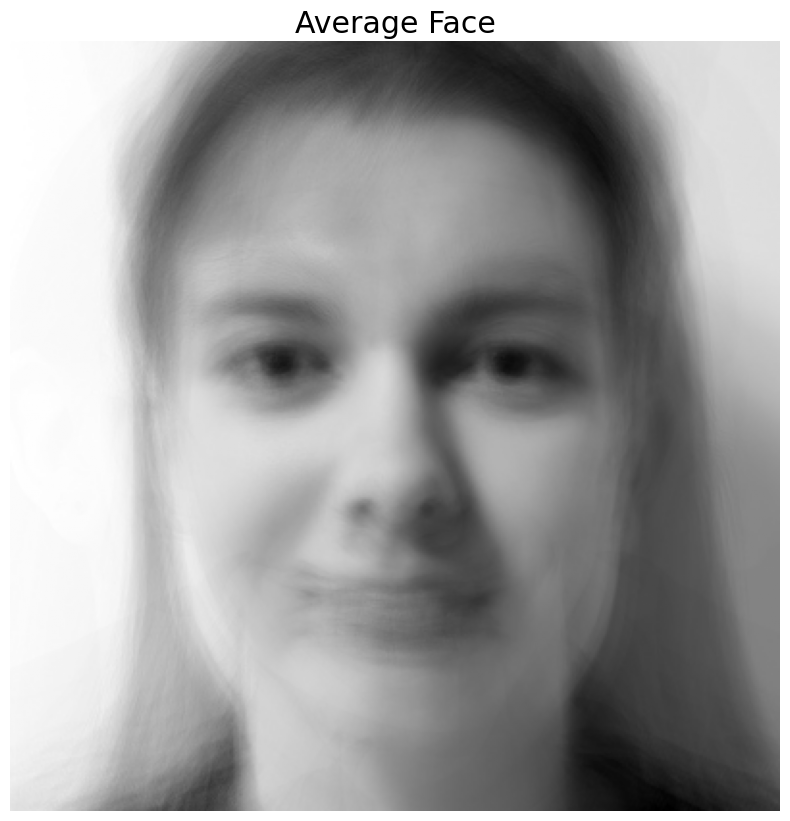

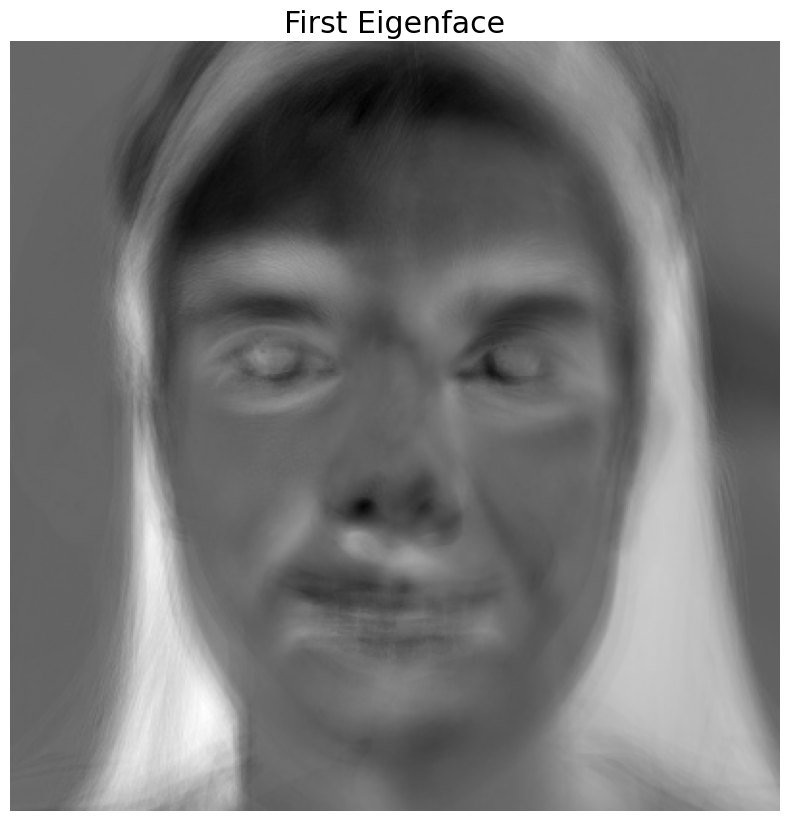

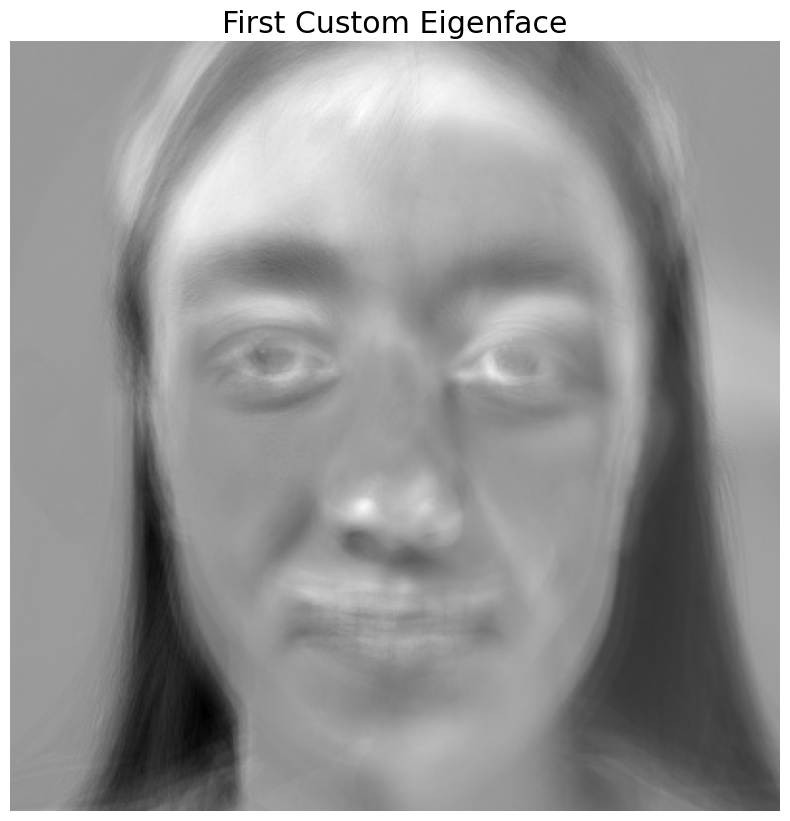

In [3]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 18})


def load_images_from_folder(folder, image_size=None):
    images = []
    filenames = sorted(os.listdir(folder))
    for filename in filenames:
        filepath = os.path.join(folder, filename)
        try:
            img = Image.open(filepath).convert('L')
            if image_size is not None:
                img = img.resize(image_size)
            img_array = np.array(img, dtype=np.float64)
            images.append(img_array)
        except Exception as e:
            print(f"Error loading {filepath}: {e}")
    return images



dataset_path = 'output_images'
subjects = os.listdir(dataset_path)
subjects = [s for s in subjects if os.path.isdir(os.path.join(dataset_path, s))]
subject_images = {}
sample_img = load_images_from_folder(os.path.join(dataset_path, subjects[0]))

if len(sample_img) == 0:
    raise ValueError("No images found in the first subject folder.")
img_shape = sample_img[0].shape


print("Image size:", img_shape)


for subject in subjects:
    folder = os.path.join(dataset_path, subject)
    imgs = load_images_from_folder(folder, image_size=img_shape)
    if len(imgs) > 0:
        subject_images[subject] = imgs


all_faces = []
labels = []
for subject, imgs in subject_images.items():
    for img in imgs:
        all_faces.append(img.flatten())
        labels.append(subject)

all_faces = np.array(all_faces).T
print("Training data matrix shape:", all_faces.shape)


avg_face = np.mean(all_faces, axis=1).reshape(-1, 1)
X = all_faces - np.tile(avg_face, (1, all_faces.shape[1]))


U, S, VT = np.linalg.svd(X, full_matrices=False)

XtX = np.dot(X.T, X)
eigvals, eigvecs = np.linalg.eigh(XtX)

sorted_indices = np.argsort(eigvals)[::-1]
eigvals = eigvals[sorted_indices]
eigvecs = eigvecs[:, sorted_indices]

U_custom = np.dot(X, eigvecs)
U_custom = U_custom / np.linalg.norm(U_custom, axis=0)

plt.figure()
plt.imshow(avg_face.reshape(img_shape), cmap='gray')
plt.title("Average Face")
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(U[:,0].reshape(img_shape), cmap='gray')
plt.title("First Eigenface")
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(U_custom[:,0].reshape(img_shape), cmap='gray')
plt.title("First Custom Eigenface")
plt.axis('off')
plt.show()

True
Predicted subject: sofia (True subject: sofia)


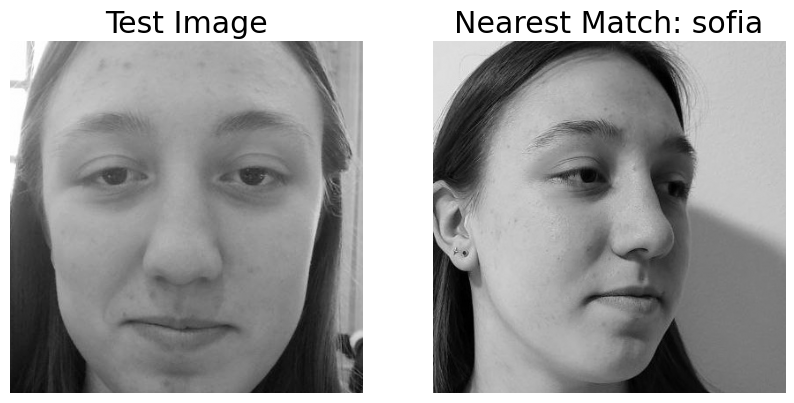

In [15]:
K = 20
eigenfaces = U_custom[:, :K]
proj_train = eigenfaces.T @ X

def classify_face(test_img, avg_face, eigenfaces, proj_train, labels):
    """
    Given a test image (2D array), subtract the average face, project onto
    eigenfaces, and classify by nearest neighbor in eigenface space.
    """
    test_vector = test_img.flatten().reshape(-1, 1)
    test_vector_centered = test_vector - avg_face
    proj_test = eigenfaces.T @ test_vector_centered  # shape: (K,1)

    distances = norm(proj_train - proj_test, axis=0)
    best_match_index = np.argmin(distances)
    predicted_label = labels[best_match_index]
    return predicted_label, distances[best_match_index], proj_test

demo_subject = "sofia"
image_path = "test_image.jpg"
print(os.path.exists(image_path))
demo_img = center_and_crop_face(image_path)
predicted_label, distance, proj_test = classify_face(demo_img, avg_face, eigenfaces, proj_train, labels)
print(f"Predicted subject: {predicted_label} (True subject: {demo_subject})")

plt.figure(figsize=(10, 5))
plt.subplot(1,2,1)
plt.imshow(demo_img, cmap='gray')
plt.title("Test Image")
plt.axis('off')

best_match_vector = all_faces[:, np.argmin(norm(proj_train - proj_test, axis=0))]
best_match_img = best_match_vector.reshape(img_shape)
plt.subplot(1,2,2)
plt.imshow(best_match_img, cmap='gray')
plt.title(f"Nearest Match: {predicted_label}")
plt.axis('off')

plt.show()

C:\Users\admin\AppData\Local\Temp\ipykernel_7528\573119331.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('jet', len(unique_labels))


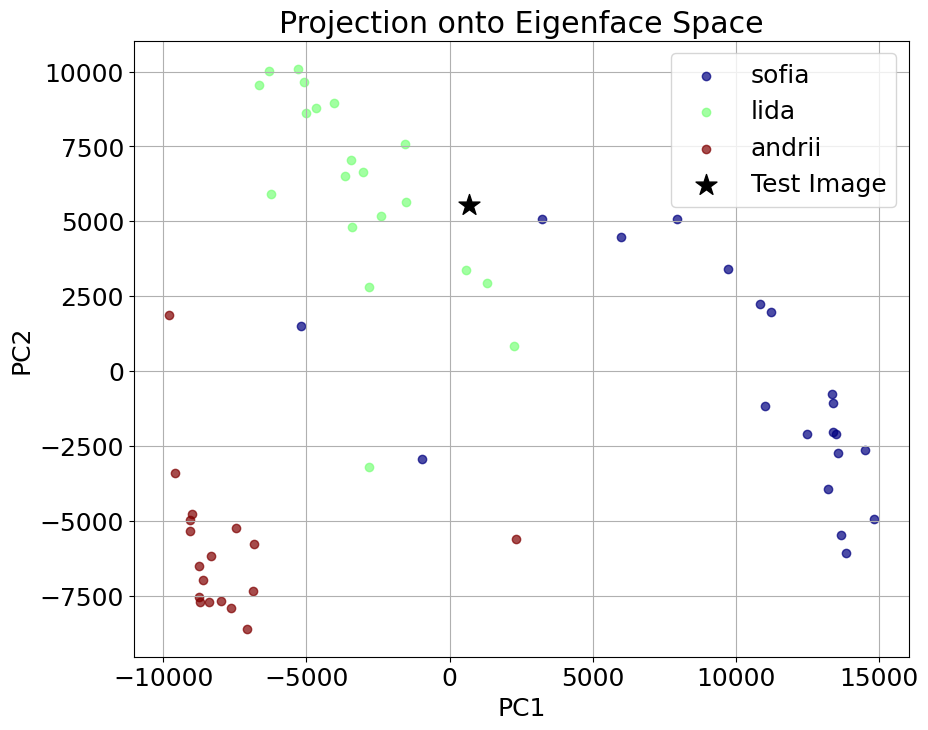

In [14]:
def load_and_preprocess_image(image_path, img_shape):
    """
    Load an image from the given path, convert it to grayscale, resize to img_shape,
    and flatten it.
    """
    img = Image.open(image_path).convert('L')
    img = img.resize((img_shape[1], img_shape[0]))
    return np.array(img, dtype=np.float64)

def project_image(test_img, avg_face, eigenfaces):
    """
    Center and project a test image onto the eigenface space.
    """
    test_vector = test_img.flatten().reshape(-1, 1)
    test_vector_centered = test_vector - avg_face
    proj_test = eigenfaces.T @ test_vector_centered
    return proj_test

def plot_projection(proj_train, labels, proj_test, unique_labels):
    """
    Plot the training projections and the test image projection.
    """
    PC1_train = proj_train[0, :]
    PC2_train = proj_train[1, :]

    colors = plt.cm.get_cmap('jet', len(unique_labels))
    label_color_map = {label: colors(i) for i, label in enumerate(unique_labels)}

    plt.figure(figsize=(10, 8))
    for label in unique_labels:
        indices = [i for i, lab in enumerate(labels) if lab == label]
        plt.scatter(PC1_train[indices], PC2_train[indices],
                    color=label_color_map[label], label=label, alpha=0.7)

    PC1_test = proj_test[0, 0]
    PC2_test = proj_test[1, 0]
    plt.scatter(PC1_test, PC2_test, color='black', marker='*', s=250, label='Test Image')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Projection onto Eigenface Space')
    plt.legend()
    plt.grid(True)
    plt.show()

unique_lables = ["sofia", "lida", "andrii"]

new_image_path = "test_image.jpg"  # update with your file path
new_img = load_and_preprocess_image(new_image_path, img_shape)
proj_test = project_image(new_img, avg_face, eigenfaces)
plot_projection(proj_train, labels, proj_test, unique_lables)
